In [1]:
# Install a conda package in the current Jupyter kernel
import sys
#!conda install --yes --prefix {sys.prefix} numpy

In [2]:
import tweepy
import requests
from bs4 import BeautifulSoup as bs
import pandas as pd
import numpy as np
import timeit
import os
import json
from pprint import pprint
from numpy import nan
from matplotlib import pyplot as plt
% matplotlib inline
import nltk
from nltk.corpus import stopwords
from ggplot import *
from sqlalchemy import create_engine

/opt/conda/lib/python3.6/site-packages/ggplot/utils.py:81: FutureWarning: pandas.tslib is deprecated and will be removed in a future version.
You can access Timestamp as pandas.Timestamp
  pd.tslib.Timestamp,
/opt/conda/lib/python3.6/site-packages/ggplot/stats/smoothers.py:4: FutureWarning: The pandas.lib module is deprecated and will be removed in a future version. These are private functions and can be accessed from pandas._libs.lib instead
  from pandas.lib import Timestamp
/opt/conda/lib/python3.6/site-packages/statsmodels/compat/pandas.py:56: FutureWarning: The pandas.core.datetools module is deprecated and will be removed in a future version. Please use the pandas.tseries module instead.
  from pandas.core import datetools


In [3]:
## Twitter API Parameters ##
consumer_key = 'QIi8hzBzJbczjdMXQhZwTlCNU'
consumer_secret = 'AkGfmDoIoeOlCqXUBWuM0B5PQqHtG28nIft92Rk2GxJ7evjaqv'
access_token = '16823411-DpbGnCQAiZ2OYiRw2X8qqLlSuVjOU8H8kFhqew7Ct'
access_secret = 'v8aLJoi3Gybve7eSkMYbFobxgc2o9gjPslJPyRPo6ahd5'

auth = tweepy.OAuthHandler(consumer_key, consumer_secret)
auth.set_access_token(access_token, access_secret)

api = tweepy.API(auth,wait_on_rate_limit=True,wait_on_rate_limit_notify=True)

# Gather

### 1. We RateDogs Twitter archive

In [4]:
twitter_df = pd.read_csv('twitter-archive-enhanced.csv')

In [5]:
twitter_df.head(2)

,tweet_id,in_reply_to_status_id,in_reply_to_user_id,timestamp,source,text,retweeted_status_id,retweeted_status_user_id,retweeted_status_timestamp,expanded_urls,rating_numerator,rating_denominator,name,doggo,floofer,pupper,puppo
0,892420643555336193,NaN,NaN,2017-08-01 16:23:56 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Phineas. He's a mystical boy. Only eve...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/892420643...,13,10,Phineas,None,None,None,None
1,892177421306343426,NaN,NaN,2017-08-01 00:17:27 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Tilly. She's just checking pup on you....,NaN,NaN,NaN,https://twitter.com/dog_rates/status/892177421...,13,10,Tilly,None,None,None,None


In [6]:
## Generating random sample for inspection ##
twitter_df.tweet_id.sample(1)

1052    742528092657332225
Name: tweet_id, dtype: int64

In [7]:
twitter_df.query('tweet_id==884441805382717440')

,tweet_id,in_reply_to_status_id,in_reply_to_user_id,timestamp,source,text,retweeted_status_id,retweeted_status_user_id,retweeted_status_timestamp,expanded_urls,rating_numerator,rating_denominator,name,doggo,floofer,pupper,puppo
41,884441805382717440,NaN,NaN,2017-07-10 15:58:53 +0000,"<a href=""http://twitter.com/download/iphone"" r...","I present to you, Pup in Hat. Pup in Hat is gr...",NaN,NaN,NaN,https://twitter.com/dog_rates/status/884441805...,14,10,None,None,None,None,None


### 2. Tweet Image Predictions

In [8]:
## Downloading file programmatically ##
url = 'https://d17h27t6h515a5.cloudfront.net/topher/2017/August/599fd2ad_image-predictions/image-predictions.tsv'
response = requests.get(url)

In [9]:
## Creating a file named image-predicitons.tsv ##
with open(url.split('/')[-1], mode='wb') as file:
    file.write(response.content)

In [10]:
## Reading file as tab delimited file ##
image_pred_df = pd.read_csv('image-predictions.tsv', sep='\t')
image_pred_df.head(2)

,tweet_id,jpg_url,img_num,p1,p1_conf,p1_dog,p2,p2_conf,p2_dog,p3,p3_conf,p3_dog
0,666020888022790149,https://pbs.twimg.com/media/CT4udn0WwAA0aMy.jpg,1,Welsh_springer_spaniel,0.465074,True,collie,0.156665,True,Shetland_sheepdog,0.061428,True
1,666029285002620928,https://pbs.twimg.com/media/CT42GRgUYAA5iDo.jpg,1,redbone,0.506826,True,miniature_pinscher,0.074192,True,Rhodesian_ridgeback,0.072010,True


In [11]:
image_pred_df.query('tweet_id == 884441805382717440')

,tweet_id,jpg_url,img_num,p1,p1_conf,p1_dog,p2,p2_conf,p2_dog,p3,p3_conf,p3_dog
2036,884441805382717440,https://pbs.twimg.com/media/DEYrIZwWsAA2Wo5.jpg,1,Pembroke,0.993225,True,Cardigan,0.003216,True,Chihuahua,0.002081,True


### 3. tweet_json.txt

In [12]:
'''
## Reading tweets via tweepy by passing each tweet id ##
with open('tweet_json.txt', 'w') as f_out:
    for tweet_id_elem in twitter_df['tweet_id']:
        try:
            tweet = api.get_status(tweet_id_elem,tweet_mode='extended')
            tweet_dict = {              
                'id': str(tweet_id_elem),
                'retweet_count': str(tweet.retweet_count) ,
                'favorite_count': str(tweet.favorite_count)
            }
            json.dump(tweet_dict, f_out)            
            f_out.write("\n")
        except:
            print("Error for: " + str(tweet_id_elem))

f_out.close()
'''

'\n## Reading tweets via tweepy by passing each tweet id ##\nwith open(\'tweet_json.txt\', \'w\') as f_out:\n    for tweet_id_elem in twitter_df[\'tweet_id\']:\n        try:\n            tweet = api.get_status(tweet_id_elem,tweet_mode=\'extended\')\n            tweet_dict = {              \n                \'id\': str(tweet_id_elem),\n                \'retweet_count\': str(tweet.retweet_count) ,\n                \'favorite_count\': str(tweet.favorite_count)\n            }\n            json.dump(tweet_dict, f_out)            \n            f_out.write("\n")\n        except:\n            print("Error for: " + str(tweet_id_elem))\n\nf_out.close()\n'

In [13]:
## Reading the generated tweet_json.txt file as json/dict ##
data={}
data['tweets']=[]
with open('tweet_json.txt', 'r') as f_in:
    content = f_in.readlines()
# you may also want to remove whitespace characters like `\n` at the end of each line
content = [x.strip() for x in content] 
for e in content:
    data['tweets'].append(json.loads(e))

data['tweets'][0]
#data['tweets'][0]['id']

{'favorite_count': '38794',
 'id': '892420643555336193',
 'retweet_count': '8584'}

In [14]:
## Re-Ording Columns ##
tweet_json_df = pd.DataFrame(columns= ['id','retweet_count', 'favorite_count'])

In [15]:
tweet_json_df.loc['id'] = data['tweets'][0]['id'] 
tweet_json_df['id']

id    892420643555336193
Name: id, dtype: object

In [16]:
tweet_json_df = []
for ele in data['tweets']:
    tweet_json_df.append({'id':ele['id'],
                         'retweet_count':ele['retweet_count'],
                         'favorite_count':ele['favorite_count']}
                        )
tweet_json_df = pd.DataFrame(tweet_json_df)
tweet_json_df.head(2)

,favorite_count,id,retweet_count
0,38794,892420643555336193,8584
1,33230,892177421306343426,6309


# Assess

### 1. We RateDogs Twitter archive

In [17]:
for i, v in enumerate(twitter_df.columns):
    print(i, v)

0 tweet_id
1 in_reply_to_status_id
2 in_reply_to_user_id
3 timestamp
4 source
5 text
6 retweeted_status_id
7 retweeted_status_user_id
8 retweeted_status_timestamp
9 expanded_urls
10 rating_numerator
11 rating_denominator
12 name
13 doggo
14 floofer
15 pupper
16 puppo


In [18]:
twitter_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2356 entries, 0 to 2355
Data columns (total 17 columns):
tweet_id                      2356 non-null int64
in_reply_to_status_id         78 non-null float64
in_reply_to_user_id           78 non-null float64
timestamp                     2356 non-null object
source                        2356 non-null object
text                          2356 non-null object
retweeted_status_id           181 non-null float64
retweeted_status_user_id      181 non-null float64
retweeted_status_timestamp    181 non-null object
expanded_urls                 2297 non-null object
rating_numerator              2356 non-null int64
rating_denominator            2356 non-null int64
name                          2356 non-null object
doggo                         2356 non-null object
floofer                       2356 non-null object
pupper                        2356 non-null object
puppo                         2356 non-null object
dtypes: float64(4), int64(3), ob

In [19]:
twitter_df.dtypes

tweet_id                        int64
in_reply_to_status_id         float64
in_reply_to_user_id           float64
timestamp                      object
source                         object
text                           object
retweeted_status_id           float64
retweeted_status_user_id      float64
retweeted_status_timestamp     object
expanded_urls                  object
rating_numerator                int64
rating_denominator              int64
name                           object
doggo                          object
floofer                        object
pupper                         object
puppo                          object
dtype: object

In [20]:
twitter_df.nunique()

tweet_id                      2356
in_reply_to_status_id           77
in_reply_to_user_id             31
timestamp                     2356
source                           4
text                          2356
retweeted_status_id            181
retweeted_status_user_id        25
retweeted_status_timestamp     181
expanded_urls                 2218
rating_numerator                40
rating_denominator              18
name                           957
doggo                            2
floofer                          2
pupper                           2
puppo                            2
dtype: int64

In [21]:
twitter_df.tweet_id.sample(1)

1046    743545585370791937
Name: tweet_id, dtype: int64

In [22]:
tweets = api.get_status(704480331685040129,tweet_mode='extended')

In [23]:
#tweets_json = json.dumps(tweets._json, indent=4)
print(tweets)

Status(_api=<tweepy.api.API object at 0x7f0759b12a58>, _json={'created_at': 'Tue Mar 01 01:36:14 +0000 2016', 'id': 704480331685040129, 'id_str': '704480331685040129', 'full_text': "Meet Lucia. She's a Cumulonimbus Floofmallow. Only has two legs tho (unfortunate). 11/10 would definitely still pet https://t.co/qv6qlEUCEe", 'truncated': False, 'display_text_range': [0, 139], 'entities': {'hashtags': [], 'symbols': [], 'user_mentions': [], 'urls': [], 'media': [{'id': 704480327234953220, 'id_str': '704480327234953220', 'indices': [116, 139], 'media_url': 'http://pbs.twimg.com/media/CcbRIAgXIAQaKHQ.jpg', 'media_url_https': 'https://pbs.twimg.com/media/CcbRIAgXIAQaKHQ.jpg', 'url': 'https://t.co/qv6qlEUCEe', 'display_url': 'pic.twitter.com/qv6qlEUCEe', 'expanded_url': 'https://twitter.com/dog_rates/status/704480331685040129/photo/1', 'type': 'photo', 'sizes': {'thumb': {'w': 150, 'h': 150, 'resize': 'crop'}, 'small': {'w': 510, 'h': 680, 'resize': 'fit'}, 'large': {'w': 768, 'h': 1024, 'resi

In [24]:
tweets.retweet_count

1156

In [25]:
tweets.favorite_count

3639

In [26]:
twitter_df.in_reply_to_status_id.isnull().sum()

2278

In [27]:
## ratimg denominator ##
sorted(twitter_df.rating_denominator.unique())

[0, 2, 7, 10, 11, 15, 16, 20, 40, 50, 70, 80, 90, 110, 120, 130, 150, 170]

In [28]:
## ratimg numerator ##
twitter_df.rating_numerator.nunique()

40

In [29]:
## Non-Values snip that will be removed ##
twitter_df[twitter_df.in_reply_to_status_id.notnull()]['in_reply_to_status_id'][0:5]

30     8.862664e+17
55     8.816070e+17
64     8.795538e+17
113    8.707262e+17
148    8.634256e+17
Name: in_reply_to_status_id, dtype: float64

In [30]:
## Twitter Source unique Levels ##
'''This will be cleaned to have html tags removed later'''
twitter_df['source'].unique() 

array([ '<a href="http://twitter.com/download/iphone" rel="nofollow">Twitter for iPhone</a>',
       '<a href="http://twitter.com" rel="nofollow">Twitter Web Client</a>',
       '<a href="http://vine.co" rel="nofollow">Vine - Make a Scene</a>',
       '<a href="https://about.twitter.com/products/tweetdeck" rel="nofollow">TweetDeck</a>'], dtype=object)

In [31]:
## Checking if dog stage name has multiple values ##
for index, row in twitter_df.iterrows():
    if(row['doggo']  != "None" and row['floofer'] != "None"):
        print('doggo and floofer Index is:', index)   
    elif(row['floofer']  != "None" and row['pupper'] != "None"):
        print('floofer and pupper Index is:', index)    
    elif(row['pupper']  != "None" and row['puppo'] != "None"):
        print('pupper and puppo Index is:', index)       
    elif(row['puppo']  != "None" and row['floofer'] != "None"):
        print('puppo and floofer Index is:', index)        
    elif(row['puppo']  != "None" and row['doggo'] != "None"):
        print('puppo and doggo Index is:', index)

puppo and doggo Index is: 191
doggo and floofer Index is: 200


#### Quality

1- Missing data (Nan values)

    - in_reply_to_status_id         2278 missnig
    - in_reply_to_user_id           2278 missnig 
    - retweeted_status_id           2175 missnig 
    - retweeted_status_user_id      2175 missnig 
    - retweeted_status_timestamp    2175 missnig
    - expanded_urls                 59   missnig

2- Invalid Data
    - rating_numerator having score values more than 10
    - rating_denominator having 18 uniuqe instead of a unified score of 10.
    - '+0000' at the end of each timestamp
    - 'href' in image source column rather than the raw link.

3- Duplicate data
    - Re-tweeted tweets (181 retweets) needs to be removed, since they are not original tweets, hence duplicate ones.
    - in_reply_to_status_id (78 Replies) needs to be removed
4- Inaccuracy - Typos 
    - Two dogs having two stage names. 
      (Change index 191 to doggo and 200 to floofer)
    - Mispelled dog names, missing dog names and labeled as None.
    
5- Wrong Data Types
    - timestamp will be converted to Date and Time later in Tidness part.
      Date should be date object.
    - Converting tweet_id to string in all dataframes for the merge to happen.
    - Convert favorite count and retweet count to int in the master dataframe (twitter_df) after the merge to find corelation

6- Consistency 
    - Rename 'id' to 'tweet_id' in tweet_json_df and image_pred_df. 
    - Change datatype of it to str so we can merge it later with twitter_enhanced_archive

#### Tidness

- Multiple columns for dog stage name should be one column
- Two value in one column (date and time) in timestamp
- Re-Arrange columns in twitter_df
- Tweet_json.txt should be merged with twitter-archived-enhanced

### 2. Tweet Image Predictions

In [32]:
image_pred_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2075 entries, 0 to 2074
Data columns (total 12 columns):
tweet_id    2075 non-null int64
jpg_url     2075 non-null object
img_num     2075 non-null int64
p1          2075 non-null object
p1_conf     2075 non-null float64
p1_dog      2075 non-null bool
p2          2075 non-null object
p2_conf     2075 non-null float64
p2_dog      2075 non-null bool
p3          2075 non-null object
p3_conf     2075 non-null float64
p3_dog      2075 non-null bool
dtypes: bool(3), float64(3), int64(2), object(4)
memory usage: 152.1+ KB


### 3. tweet_json.txt

In [33]:
cols = tweet_json_df.columns.tolist()
cols

['favorite_count', 'id', 'retweet_count']

In [34]:
# Re-Ordering Columns
cols = cols[1:] + cols[:1]
cols
tweet_json_df = tweet_json_df[cols]
tweet_json_df.head(2)

,id,retweet_count,favorite_count
0,892420643555336193,8584,38794
1,892177421306343426,6309,33230


In [35]:
tweet_json_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2345 entries, 0 to 2344
Data columns (total 3 columns):
id                2345 non-null object
retweet_count     2345 non-null object
favorite_count    2345 non-null object
dtypes: object(3)
memory usage: 55.0+ KB


#### Tidness

- For the text file, the two columns will be merged with the twitter enhanced archive dataset 'twitter_df' 

# Clean

In [36]:
# Copy the dataframes 
twitter_df_clean = twitter_df.copy()
image_pred_df_clean = image_pred_df.copy()
tweet_json_df_clean = tweet_json_df.copy()

### 1. We RateDogs Twitter archive

#### `Missing data`: (Nan values) in several columns

##### Define

Inspect tweepy parameters, to see if values can be filled by the tweepy

##### Code

In [37]:
print(json.dumps(tweets._json, indent=4))

{
    "created_at": "Tue Mar 01 01:36:14 +0000 2016",
    "id": 704480331685040129,
    "id_str": "704480331685040129",
    "full_text": "Meet Lucia. She's a Cumulonimbus Floofmallow. Only has two legs tho (unfortunate). 11/10 would definitely still pet https://t.co/qv6qlEUCEe",
    "truncated": false,
    "display_text_range": [
        0,
        139
    ],
    "entities": {
        "hashtags": [],
        "symbols": [],
        "user_mentions": [],
        "urls": [],
        "media": [
            {
                "id": 704480327234953220,
                "id_str": "704480327234953220",
                "indices": [
                    116,
                    139
                ],
                "media_url": "http://pbs.twimg.com/media/CcbRIAgXIAQaKHQ.jpg",
                "media_url_https": "https://pbs.twimg.com/media/CcbRIAgXIAQaKHQ.jpg",
                "url": "https://t.co/qv6qlEUCEe",
                "display_url": "pic.twitter.com/qv6qlEUCEe",
                "expanded_ur

#### `Invalid Data`: rating_denominator having score values more than 10

##### Define

Some denominator have values more than 10, we will make it constant to 10

##### Code

In [38]:
twitter_df_clean.loc[twitter_df_clean.rating_denominator != 10, 'rating_denominator'] = 10

##### Test

In [39]:
sum(twitter_df_clean.rating_denominator > 10)

0

#### `Invalid Data`: rating_numerator having score values more than 10

##### Define

Unifying values that are above 10 to only 10, as the denominator is 10

##### Code

In [40]:
twitter_df_clean.loc[twitter_df_clean.rating_numerator > 10, 'rating_numerator'] = 10

##### Test

In [41]:
sum(twitter_df_clean.rating_numerator > 10)

0

#### `Invalid Data`: '+0000' at the end of each timestamp - Creating timestamp to date object.

##### Define

Remove the time zone as it's not needed and it will affect the value if casted to date object.
This will be done in the below code.

##### Code

In [42]:
## Removing time zone.
twitter_df_clean['timestamp'] = twitter_df_clean['timestamp'].str[:-5]

In [43]:
## Converting time stamp to date object
twitter_df_clean['timestamp'] = pd.to_datetime(twitter_df_clean['timestamp'])

##### Test

In [44]:
## Postfix test
twitter_df_clean['timestamp'].sample(5)

1851   2015-12-12 16:16:45
1032   2016-06-21 17:58:09
1991   2015-12-04 03:43:54
2197   2015-11-23 16:18:59
2303   2015-11-18 15:07:24
Name: timestamp, dtype: datetime64[ns]

In [45]:
twitter_df_clean.dtypes

tweet_id                               int64
in_reply_to_status_id                float64
in_reply_to_user_id                  float64
timestamp                     datetime64[ns]
source                                object
text                                  object
retweeted_status_id                  float64
retweeted_status_user_id             float64
retweeted_status_timestamp            object
expanded_urls                         object
rating_numerator                       int64
rating_denominator                     int64
name                                  object
doggo                                 object
floofer                               object
pupper                                object
puppo                                 object
dtype: object

#### `Data Tidness - Each variable forms a column` - Two value in one column (date and time) in timestamp

##### Define

Split time and date into two separate columns.

Remove datetime object.

##### Code

In [46]:
twitter_df_clean['date'] = twitter_df_clean['timestamp'].apply(lambda time: time.strftime('%d-%m-%Y'))
twitter_df_clean['time'] = twitter_df_clean['timestamp'].apply(lambda time: time.strftime('%H:%M:%S'))

In [47]:
twitter_df_clean.date = pd.to_datetime(twitter_df_clean.date)
twitter_df_clean.time = pd.to_datetime(twitter_df_clean.time,format= '%H:%M:%S' ).dt.time

In [48]:
## Remove timestamp column after date and time columns created ##
del twitter_df_clean['timestamp']

##### Test

In [49]:
twitter_df_clean.date.sample(2)

1451   2016-06-02
1566   2016-01-15
Name: date, dtype: datetime64[ns]

In [50]:
twitter_df_clean.time.sample(2)

1141    23:42:26
944     01:52:49
Name: time, dtype: object

In [51]:
twitter_df_clean.dtypes

tweet_id                               int64
in_reply_to_status_id                float64
in_reply_to_user_id                  float64
source                                object
text                                  object
retweeted_status_id                  float64
retweeted_status_user_id             float64
retweeted_status_timestamp            object
expanded_urls                         object
rating_numerator                       int64
rating_denominator                     int64
name                                  object
doggo                                 object
floofer                               object
pupper                                object
puppo                                 object
date                          datetime64[ns]
time                                  object
dtype: object

#### `Invalid Data`: 'href' in image source column rather than the raw link.

##### Define

Remove html tags with regular expressions

##### Code

In [52]:
## Taking everything between > and < ##
twitter_df_clean['source'] = twitter_df_clean['source'].str.extract('((?<=>).*(?=<))', expand=True)

##### Test

In [53]:
twitter_df_clean['source'].unique()

array(['Twitter for iPhone', 'Twitter Web Client', 'Vine - Make a Scene',
       'TweetDeck'], dtype=object)

#### `Duplicate Data`: Re-tweeted tweets (181 retweets) needs to be removed

##### Define

Remove any rows with tweets that have values in retweeted_status_id because this retweet is duplicate of the original tweet

##### Code

In [54]:
## Dropping (retweets): any rows that have values in retweet column ##
twitter_df_clean.drop(twitter_df_clean[twitter_df_clean.retweeted_status_id.notnull()].index, inplace=True)

##### Test

In [55]:
twitter_df_clean.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2175 entries, 0 to 2355
Data columns (total 18 columns):
tweet_id                      2175 non-null int64
in_reply_to_status_id         78 non-null float64
in_reply_to_user_id           78 non-null float64
source                        2175 non-null object
text                          2175 non-null object
retweeted_status_id           0 non-null float64
retweeted_status_user_id      0 non-null float64
retweeted_status_timestamp    0 non-null object
expanded_urls                 2117 non-null object
rating_numerator              2175 non-null int64
rating_denominator            2175 non-null int64
name                          2175 non-null object
doggo                         2175 non-null object
floofer                       2175 non-null object
pupper                        2175 non-null object
puppo                         2175 non-null object
date                          2175 non-null datetime64[ns]
time                          

In [56]:
## Removing columns after that ##
twitter_df_clean = twitter_df_clean.drop(['retweeted_status_id', 'retweeted_status_user_id','retweeted_status_timestamp'], axis=1)

#### `Duplicate Data`: in_reply_to_status_id (78 Replies) needs to be removed

##### Define

Remove a replied tweets as they are duplicate as well

##### Code

In [57]:
## Dropping (replies): any rows that have values in replies column ##
twitter_df_clean.drop(twitter_df_clean[twitter_df_clean.in_reply_to_status_id.notnull()].index, inplace=True)

In [58]:
## Removing columns after that ##
twitter_df_clean = twitter_df_clean.drop(['in_reply_to_status_id', 'in_reply_to_user_id'], axis=1)

##### Test

In [59]:
twitter_df_clean.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2097 entries, 0 to 2355
Data columns (total 13 columns):
tweet_id              2097 non-null int64
source                2097 non-null object
text                  2097 non-null object
expanded_urls         2094 non-null object
rating_numerator      2097 non-null int64
rating_denominator    2097 non-null int64
name                  2097 non-null object
doggo                 2097 non-null object
floofer               2097 non-null object
pupper                2097 non-null object
puppo                 2097 non-null object
date                  2097 non-null datetime64[ns]
time                  2097 non-null object
dtypes: datetime64[ns](1), int64(3), object(9)
memory usage: 229.4+ KB


#### `Inaccuracy` Two dogs having two stage names.

##### Define

Find the correct name by cross-refencing text and remove the fault decoy named.

##### Code

In [60]:
## Row having two values for dog stage name ##
twitter_df_clean.loc[191]

tweet_id                                             855851453814013952
source                                               Twitter for iPhone
text                  Here's a puppo participating in the #ScienceMa...
expanded_urls         https://twitter.com/dog_rates/status/855851453...
rating_numerator                                                     10
rating_denominator                                                   10
name                                                               None
doggo                                                             doggo
floofer                                                            None
pupper                                                             None
puppo                                                             puppo
date                                                2017-04-22 00:00:00
time                                                           18:31:02
Name: 191, dtype: object

In [61]:
## Row having two values for dog stage name ##
twitter_df_clean.loc[200]

tweet_id                                             854010172552949760
source                                               Twitter for iPhone
text                  At first I thought this was a shy doggo, but i...
expanded_urls         https://twitter.com/dog_rates/status/854010172...
rating_numerator                                                     10
rating_denominator                                                   10
name                                                               None
doggo                                                             doggo
floofer                                                         floofer
pupper                                                             None
puppo                                                              None
date                                                2017-04-17 00:00:00
time                                                           16:34:26
Name: 200, dtype: object

In [62]:
twitter_df_clean['stage_name']="None"
twitter_df_clean.iloc[191,13]="puppo"
twitter_df_clean.iloc[200,13]="floofer"

twitter_df_clean.iloc[191,7]="None"
twitter_df_clean.iloc[200,7]="None"

##### Test

In [63]:
twitter_df_clean.loc[191]

tweet_id                                             855851453814013952
source                                               Twitter for iPhone
text                  Here's a puppo participating in the #ScienceMa...
expanded_urls         https://twitter.com/dog_rates/status/855851453...
rating_numerator                                                     10
rating_denominator                                                   10
name                                                               None
doggo                                                             doggo
floofer                                                            None
pupper                                                             None
puppo                                                             puppo
date                                                2017-04-22 00:00:00
time                                                           18:31:02
stage_name                                                      

In [64]:
twitter_df_clean.loc[200]

tweet_id                                             854010172552949760
source                                               Twitter for iPhone
text                  At first I thought this was a shy doggo, but i...
expanded_urls         https://twitter.com/dog_rates/status/854010172...
rating_numerator                                                     10
rating_denominator                                                   10
name                                                               None
doggo                                                             doggo
floofer                                                         floofer
pupper                                                             None
puppo                                                              None
date                                                2017-04-17 00:00:00
time                                                           16:34:26
stage_name                                                      

#### `Inaccuracy`  Mispelled dog names, missing dog names and labeled as None.

##### Define

- Some dogs are mispelled, because data fetched takes dogs with a certain patter. i.e this is a cute dog, where a is taken after this is

- Replace stop words with None using nltk and convert None to NaN later

##### Code

In [65]:
twitter_df.name.value_counts()[0:5]

None       745
a           55
Charlie     12
Cooper      11
Lucy        11
Name: name, dtype: int64

In [66]:
## Stop words from nltk ##
nltk.download('stopwords')
stop = stopwords.words('english')

## keep track of stop words found ##
df_stop_words_found=twitter_df_clean['name'].apply(lambda x: 'None'.join([word for word in x.split() if word in (stop)]))

## If the name is in stop words, then replace it with '' #
twitter_df_clean['name']=twitter_df_clean['name'].apply(lambda x: ''.join([word for word in x.split() if word not in (stop)]))

## Convert '' to NaN ##
twitter_df_clean.name.replace('',np.nan,inplace=True)

print('Stop words found:')
df_stop_words_found.value_counts()[1:]

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
Stop words found:


a       55
the      8
an       6
very     4
just     3
not      2
my       1
such     1
his      1
by       1
this     1
all      1
Name: name, dtype: int64

In [67]:
## Replacing other values that were inspected visually ##
#twitter_df_clean.name.unique()
twitter_df_clean['name'].replace('one',np.nan,inplace=True)
twitter_df_clean['name'].replace('O',np.nan,inplace=True)
twitter_df_clean['name'].replace('actually',np.nan,inplace=True)
twitter_df_clean['name'].replace('getting',np.nan,inplace=True)
twitter_df_clean['name'].replace('old',np.nan,inplace=True)
twitter_df_clean['name'].replace('quite',np.nan,inplace=True)

##### Test

In [68]:
twitter_df_clean.name.value_counts()[0:5]

None       603
Lucy        11
Charlie     11
Oliver      10
Cooper      10
Name: name, dtype: int64

#### `Data Tidness - Variables are stored in both rows and columns` Multiple columns for dog stage name should be one column

Put the dog stage name in a separate variable.

Remove the 4 columns after creating 'dog_stage' variable

##### Code

In [69]:
## If one of the 4 columns is not empty / then fill this value in the newly created stage_name column ##
for index, row in twitter_df_clean.iterrows():
    if(row['doggo'] != "None"):
        twitter_df_clean.iloc[row.name,13]="doggo"
    elif(row['floofer'] != "None"):
        twitter_df_clean.iloc[row.name,13]="floofer"
    elif(row['pupper'] != "None"):
        twitter_df_clean.iloc[row.name,13]="pupper"
    elif(row['puppo'] != "None"):
        twitter_df_clean.iloc[row.name,13]="puppo"
        

In [70]:
# Replacing None with NaNs ##
twitter_df_clean.stage_name.replace('None',np.nan, inplace=True)

In [71]:
## Remove the 4 columns ##
twitter_df_clean = twitter_df_clean.drop(['doggo', 'floofer','pupper','puppo'], axis=1)

##### Test

In [72]:
## Value filled ##
twitter_df_clean.groupby('stage_name')['stage_name'].count()

stage_name
doggo       83
floofer      9
pupper     221
puppo       23
Name: stage_name, dtype: int64

In [73]:
## NaNs value for dog stage name ##
twitter_df_clean.stage_name.isnull().sum()

1761

In [74]:
twitter_df_clean.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2097 entries, 0 to 2355
Data columns (total 10 columns):
tweet_id              2097 non-null int64
source                2097 non-null object
text                  2097 non-null object
expanded_urls         2094 non-null object
rating_numerator      2097 non-null int64
rating_denominator    2097 non-null int64
name                  2000 non-null object
date                  2097 non-null datetime64[ns]
time                  2097 non-null object
stage_name            336 non-null object
dtypes: datetime64[ns](1), int64(3), object(6)
memory usage: 260.2+ KB


#### `Data Consistency - Inconsistent column names accross dataframe` Rename id to twitter id in tweet_json_df


##### Define

Rename id to tweet_id in tweet_json_df and image_pred_df

Convert tweet_id to str in both dataframe [tweet_json_df and twitter_df]

##### Code

In [75]:
image_pred_df.rename(columns={'id': 'tweet_id'}, inplace=True)
tweet_json_df.rename(columns={'id': 'tweet_id'}, inplace=True)

In [76]:
tweet_json_df_clean['tweet_id'] = tweet_json_df['tweet_id'].astype(str)
twitter_df_clean['tweet_id'] =  twitter_df['tweet_id'].astype(str)

##### Test

In [77]:
tweet_json_df_clean.id.dtypes

dtype('O')

#### `Data Tidness ` - Tweet_json.txt should be merged with twitter-archived-enhanced

##### Define

Merging two columns (favourite count and retweet count) on tweet_id

##### Code

In [78]:
twitter_df_clean = pd.merge(twitter_df_clean, tweet_json_df,
                            on=['tweet_id'], how='inner')

##### Test

In [79]:
twitter_df_clean.head(2)

,tweet_id,source,text,expanded_urls,rating_numerator,rating_denominator,name,date,time,stage_name,retweet_count,favorite_count
0,892420643555336193,Twitter for iPhone,This is Phineas. He's a mystical boy. Only eve...,https://twitter.com/dog_rates/status/892420643...,10,10,Phineas,2017-01-08,16:23:56,NaN,8584,38794
1,892177421306343426,Twitter for iPhone,This is Tilly. She's just checking pup on you....,https://twitter.com/dog_rates/status/892177421...,10,10,Tilly,2017-01-08,00:17:27,NaN,6309,33230


#### `Data Consistency - wrong data type` Convert favorite count and retweet count to int

### Define

Convert favorite count and retweet count to int after the merge for corelation to happen later

### Code

In [80]:
twitter_df_clean['retweet_count'] = pd.to_numeric(twitter_df_clean.retweet_count)
twitter_df_clean['favorite_count'] = pd.to_numeric(twitter_df_clean.favorite_count)

### Test

In [81]:
twitter_df_clean[['favorite_count','retweet_count']].dtypes

favorite_count    int64
retweet_count     int64
dtype: object

#### `Data Tidness ` - Re-Arrange columns in twitter_df

##### Define

Arrange columns to make the dataset easier for reading and more tidy using reindex()

##### Code

In [82]:
columnTitles = ['tweet_id', 
                'date', 
                'time',
                'name',
                'stage_name',
                'rating_numerator',
                'rating_denominator',
               'favorite_count',
               'retweet_count',
               'source',
               'text',
               'expanded_urls']
twitter_df_clean = twitter_df_clean.reindex(columns=columnTitles)

##### Test

In [83]:
twitter_df_clean.head(10)

,tweet_id,date,time,name,stage_name,rating_numerator,rating_denominator,favorite_count,retweet_count,source,text,expanded_urls
0,892420643555336193,2017-01-08,16:23:56,Phineas,NaN,10,10,38794,8584,Twitter for iPhone,This is Phineas. He's a mystical boy. Only eve...,https://twitter.com/dog_rates/status/892420643...
1,892177421306343426,2017-01-08,00:17:27,Tilly,NaN,10,10,33230,6309,Twitter for iPhone,This is Tilly. She's just checking pup on you....,https://twitter.com/dog_rates/status/892177421...
2,891815181378084864,2017-07-31,00:18:03,Archie,NaN,10,10,25021,4190,Twitter for iPhone,This is Archie. He is a rare Norwegian Pouncin...,https://twitter.com/dog_rates/status/891815181...
3,891689557279858688,2017-07-30,15:58:51,Darla,NaN,10,10,42157,8705,Twitter for iPhone,This is Darla. She commenced a snooze mid meal...,https://twitter.com/dog_rates/status/891689557...
4,891327558926688256,2017-07-29,16:00:24,Franklin,NaN,10,10,40325,9469,Twitter for iPhone,This is Franklin. He would like you to stop ca...,https://twitter.com/dog_rates/status/891327558...
5,891087950875897856,2017-07-29,00:08:17,None,NaN,10,10,20218,3136,Twitter for iPhone,Here we have a majestic great white breaching ...,https://twitter.com/dog_rates/status/891087950...
6,890971913173991426,2017-07-28,16:27:12,Jax,NaN,10,10,11855,2087,Twitter for iPhone,Meet Jax. He enjoys ice cream so much he gets ...,"https://gofundme.com/ydvmve-surgery-for-jax,ht..."
7,890729181411237888,2017-07-28,00:22:40,None,NaN,10,10,65524,19029,Twitter for iPhone,When you watch your owner call another dog a g...,https://twitter.com/dog_rates/status/890729181...
8,890609185150312448,2017-07-27,16:25:51,Zoey,NaN,10,10,27772,4294,Twitter for iPhone,This is Zoey. She doesn't want to be one of th...,https://twitter.com/dog_rates/status/890609185...
9,890240255349198849,2017-07-26,15:59:51,Cassie,doggo,10,10,31935,7469,Twitter for iPhone,This is Cassie. She is a college pup. Studying...,https://twitter.com/dog_rates/status/890240255...


## Quality Issues

- Completeness (Is there missing data?)
- Validity (Negative height)
- Inaccuracy (Wrong data that is valid, example 27 cm height)
- Consistency (Following the same format)
- Duplicate
- Corrupted
- Typos

## Tideness Issues

- Column headers are values, not variable names.
- Multiple variables are stored in one column.
- Variables are stored in both rows and columns.
- Multiple types of observational units are stored in the same table.
- A single observational unit is stored in multiple tables.

# Data Analysis 

### Most common dog name 

In [84]:
twitter_df_clean.name.value_counts()[0:5]

None       603
Lucy        11
Charlie     11
Oliver      10
Cooper      10
Name: name, dtype: int64

### Mean of rating_numerator

In [85]:
## Mean of Denominator before cleaning ##
twitter_df[['rating_numerator','rating_denominator']].describe()

,rating_numerator,rating_denominator
count,2356.000000,2356.000000
mean,13.126486,10.455433
std,45.876648,6.745237
min,0.000000,0.000000
25%,10.000000,10.000000
50%,11.000000,10.000000
75%,12.000000,10.000000
max,1776.000000,170.000000


In [86]:
## Mean of Numerator after cleaning ##
twitter_df_clean.describe()

,rating_numerator,rating_denominator,favorite_count,retweet_count
count,2097.000000,2097.0,2097.000000,2097.000000
mean,9.447306,10.0,8929.119218,2789.356700
std,1.436046,0.0,12536.515213,4723.169264
min,0.000000,10.0,80.000000,13.000000
25%,10.000000,10.0,2002.000000,622.000000
50%,10.000000,10.0,4096.000000,1360.000000
75%,10.000000,10.0,11221.000000,3190.000000
max,10.000000,10.0,143355.000000,77334.000000


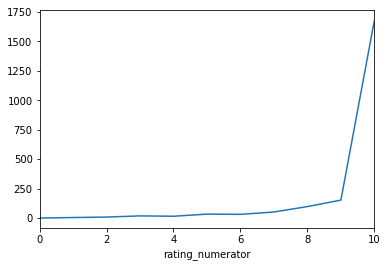

In [87]:
twitter_df_clean.groupby('rating_numerator')['rating_numerator'].count().plot()

In [88]:
twitter_df_clean['ratio']=twitter_df_clean.rating_numerator/twitter_df_clean.rating_denominator

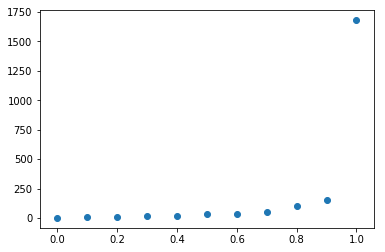

In [89]:
ratio_df=twitter_df_clean.groupby('ratio')['ratio'].count()
plt.scatter(x=ratio_df.index.get_level_values(0), y=[n for n in ratio_df.values])

In [90]:
ratio_df

ratio
0.0       1
0.1       5
0.2       9
0.3      19
0.4      16
0.5      34
0.6      32
0.7      52
0.8      98
0.9     153
1.0    1678
Name: ratio, dtype: int64

### Frequency of Source

In [91]:
twitter_df_clean.groupby('source').source.count()

source
TweetDeck                11
Twitter Web Client       31
Twitter for iPhone     1964
Vine - Make a Scene      91
Name: source, dtype: int64

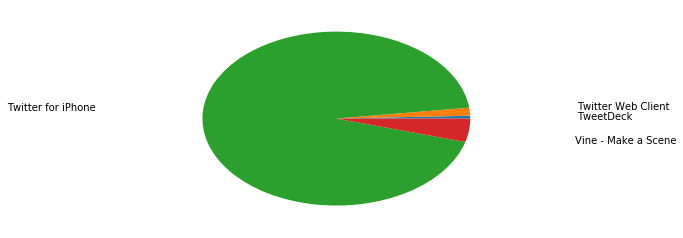

In [92]:
pie_df=twitter_df_clean.groupby('source').source.count()
plt.pie(pie_df,labels=pie_df.index.get_level_values(0),labeldistance=1.8);

### Co-relation favorite and retweet count 

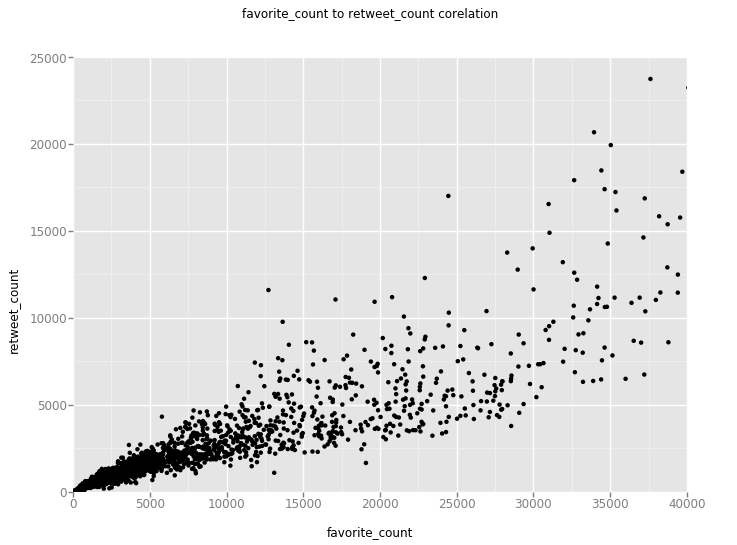

<ggplot: (-9223363307511013176)>

In [93]:
ggplot(twitter_df_clean, aes(x='favorite_count', y='retweet_count')) +\
    geom_jitter() +\
    xlim(0,40000) +\
    ylim(0,25000) +\
    ggtitle("favorite_count to retweet_count corelation") 

In [94]:
twitter_df_clean['favorite_count'].corr(twitter_df_clean['retweet_count'])

0.91555334664024801

### Database Analysis 

In [95]:
engine = create_engine('sqlite:///tweets.db')

In [97]:
#twitter_df_clean.to_sql('master', engine, index=False)

In [98]:
monthly_tweets_df = pd.read_sql("SELECT strftime('%Y-%m',date) AS 'month/year', count(*) as 'count' \
                                 FROM master \
                                 GROUP BY 1 ORDER BY 2 DESC", 
                                 engine)
monthly_tweets_df

,month/year,count
0,2015-11,311
1,2015-12,190
2,2016-01,147
3,2016-02,111
4,2016-03,108
5,2016-06,98
6,2016-10,80
7,2016-08,79
8,2016-09,78
9,2016-07,76


In [99]:
Quarterly_tweets_df =  \
pd.read_sql("SELECT strftime('%Y-%m',date) AS 'month_date', count(*) as 'count', CASE  \
                                     WHEN strftime('%m',date) IN ('01','02','03')  THEN SUBSTR(strftime('%Y-%m',date),3,2)||'Q1' \
                                     WHEN strftime('%m',date) IN ('04','05','06')  THEN SUBSTR(strftime('%Y-%m',date),3,2)||'Q2' \
                                     WHEN strftime('%m',date) IN ('07','08','09')  THEN SUBSTR(strftime('%Y-%m',date),3,2)||'Q3' \
                                     WHEN strftime('%m',date) IN ('10','11','12')  THEN SUBSTR(strftime('%Y-%m',date),3,2)||'Q4' \
                                     ELSE 'None'\
                                     END quarter \
                                 FROM master \
                                 GROUP BY quarter", 
                                 engine)
Quarterly_tweets_df

,month_date,count,quarter
0,2015-01,54,15Q1
1,2015-04,43,15Q2
2,2015-07,56,15Q3
3,2015-11,515,15Q4
4,2016-01,366,16Q1
5,2016-04,238,16Q2
6,2016-07,233,16Q3
7,2016-10,217,16Q4
8,2017-01,154,17Q1
9,2017-04,121,17Q2


## Quarter Plots ##

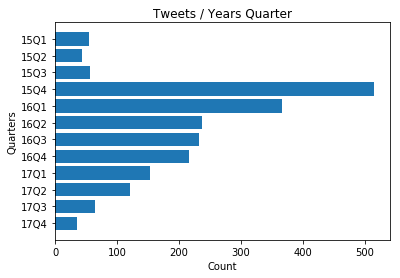

In [105]:
fig, ax = plt.subplots()
quarters=Quarterly_tweets_df['quarter']
y_pos = np.arange(len(quarters))
ax.barh(y_pos, Quarterly_tweets_df['count'], align='center')
ax.set_yticks(y_pos)
ax.set_yticklabels(quarters)
ax.invert_yaxis()
ax.set_xlabel('Count')
ax.set_ylabel('Quarters')
ax.set_title('Tweets / Years Quarter')